# Treinamento e Avaliação dos Modelos

Objetivo

#### Importação das bibliotecas necessárias

In [36]:
import pandas as pd
import random
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import (accuracy_score, confusion_matrix, classification_report,
                             roc_auc_score)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE

#### Carregamento da base de dados em um dataframe do Pandas

In [22]:
df = pd.read_csv("bases/dados_tratados.csv")

## Criação de uma variável para o número de parcelas do empréstimo

Na base de dados original, não há uma coluna com a informação do número de parcelas do empréstimo. Para que a API de predição tenha mais fidelidade com a operação real, a coluna será criada e populada com base em critérios bem definidos.

A função abaixo calcula o número de parcelas para um registro da base de dados com base no valor do empréstimo, na finalidade e no score de crédito, aplicando um ruído aleatório para garantir a variablidade nos dados.

In [23]:
def calcular_numero_parcelas(registro):

    # O número base de parcelas é baseado em faixas de valores do empréstimo
    if registro['valor_emprestimo'] <= 7500:
        parcelas = 24
    elif registro['valor_emprestimo'] <= 15000:
        parcelas = 36
    elif registro['valor_emprestimo'] <= 25000:
        parcelas = 48
    else:
        parcelas = 60
    
    # O número de parcelas é ajustado de acordo com a finalidade
    finalidade = registro['finalidade_emprestimo']
    if finalidade == 'educacao' or finalidade == 'reforma_residencial':
        parcelas += 12
    elif finalidade == 'empreendimento' or finalidade == 'saude':
        parcelas += 6

    # É feito um ajuste fino com base no score de crédito
    if registro['score_credito'] > 650:
        parcelas -=6
    elif registro['score_credito'] < 550:
        parcelas += 6

    # Adicionando ruído aleatório
    ruido = random.randint(-4, 4)
    parcelas += ruido

    # Estabelecendo um intervalo para o número de parcelas
    if parcelas < 6:
        parcelas = 6
    elif parcelas > 84:
        parcelas = 84

    # Arredondando o número de parcelas para o múltiplo de 6 mais próximo
    parcelas_final = int(round(parcelas / 6.0) * 6)

    # O retorno garante o resultado mínimo após o arredondamento
    return max(6, parcelas_final)

In [24]:
df['numero_parcelas'] = df.apply(calcular_numero_parcelas, axis=1)

Verificando o resultado

In [25]:
df.head(10)

,idade,genero,escolaridade,renda_anual,experiencia_profissional_anos,tipo_moradia,valor_emprestimo,finalidade_emprestimo,taxa_juros_emprestimo,percentual_renda_comprometida,historico_credito_anos,score_credito,inadimplencia_anterior,status_emprestimo,numero_parcelas
0,22,feminino,mestrado,71948.0,0,aluguel,35000.0,pessoal,16.02,0.49,3,561,nao,aprovado,60
1,21,feminino,ensino_medio,12282.0,0,propria,1000.0,educacao,11.14,0.08,2,504,sim,negado,42
2,25,feminino,ensino_medio,12438.0,3,financiada,5500.0,saude,12.87,0.44,3,635,nao,aprovado,36
3,23,feminino,graduacao,79753.0,0,aluguel,35000.0,saude,15.23,0.44,2,675,nao,aprovado,66
4,24,masculino,mestrado,66135.0,1,aluguel,35000.0,saude,14.27,0.53,4,586,nao,aprovado,66
5,21,feminino,ensino_medio,12951.0,0,propria,2500.0,empreendimento,7.14,0.19,2,532,nao,aprovado,36
6,26,feminino,graduacao,93471.0,1,aluguel,35000.0,educacao,12.42,0.37,3,701,nao,aprovado,66
7,24,feminino,ensino_medio,95550.0,5,aluguel,35000.0,saude,11.11,0.37,4,585,nao,aprovado,66
8,24,feminino,tecnologo,100684.0,3,aluguel,35000.0,pessoal,8.90,0.35,2,544,nao,aprovado,60
9,21,feminino,ensino_medio,12739.0,0,propria,1600.0,empreendimento,14.74,0.13,3,640,nao,aprovado,30


## Preparação dos Dados

Separando as features e a variável alvo

In [26]:
X = df.drop('status_emprestimo', axis=1)
y = df['status_emprestimo']

Separando os dados de treinamento e de teste

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

Separando as variáveis numéricas e categóricas

In [28]:
colunas_numericas = X_train.select_dtypes(include=np.number).columns.tolist()
colunas_ordinais = ['escolaridade']
escolaridade_ordem = ['ensino_medio', 'tecnologo', 'graduacao', 'mestrado', 'doutorado']
colunas_categoricas = ['genero', 'tipo_moradia', 'finalidade_emprestimo', 'inadimplencia_anterior']

Codificando a variável alvo. 0 irá representar os empréstimos negados e 1, os empréstimos aprovados

In [29]:
y_train = y_train.map({'negado': 0, 'aprovado': 1})
y_test = y_test.map({'negado': 0, 'aprovado': 1})

Criando pré-processador para codficar as variáveis categóricas

In [30]:
preprocessador = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', colunas_numericas),
        ('ord', OrdinalEncoder(categories=[escolaridade_ordem]), colunas_ordinais),
        ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False), colunas_categoricas)
    ],
    remainder='drop'
)

Aplicando o pré-processador. Para evitar vazamento dos dados de teste, o fit do pré-processador acontece apenas nos dados de treinamento

In [31]:
X_train_processado = preprocessador.fit_transform(X_train)
X_test_processado = preprocessador.transform(X_test)

## Treinamento e Avaliação dos Modelos

Os modelos que serão comparados serão a árvore de decisão, o Random Forest e o XGBoost. Haverá dois cenários de treinamento e avaliação: um cenário em que o parâmetro class_weight é passado para o modelo e um cenário em que as os dados são balanceados usando o SMOTE. Para cada cenário há uma avaliação completa do desempenho dos modelos nos testes.

Definindo a função de avaliação dos modelos

In [41]:
def avaliar_modelo(nome_modelo, y_test, y_pred, y_prob):
    print(f"----- Avaliação do Modelo: {nome_modelo} -----")

    # Acurácia
    acc = accuracy_score(y_test, y_pred)
    print(f"Acurácia: {acc:.4f}")

    # ROC AUC
    auc = roc_auc_score(y_test, y_prob)
    print(f"ROC AUC Score: {auc:.4f}")

    # Relatório de Classificação
    print("\nRelatório de Classificação:")
    print(classification_report(y_test, y_pred, target_names=['Negado (0)', 'Aprovado (1)'], zero_division=0))

    # Matriz de Confusão
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Negado', 'Aprovado'], 
                yticklabels=['Negado', 'Aprovado'])
    plt.xlabel('Predito')
    plt.ylabel('Verdadeiro')
    plt.title(f'Matriz de Confusão - {nome_modelo}')
    plt.show()

    report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
    
    if '1' in report:
        precision_1 = report['1']['precision']
        recall_1 = report['1']['recall']
        f1_score_1 = report['1']['f1-score']
    else:
        precision_1 = 0
        recall_1 = 0
        f1_score_1 = 0
        
    return {
        'acuracia': acc,
        'auc': auc,
        'precision_1': precision_1,
        'recall_1': recall_1,
        'f1_score_1': f1_score_1
    }

resultados = {}

#### Treinamento dos Modelos no cenário com class_weight

----- Avaliação do Modelo: Decision Tree (class_weight) -----
Acurácia: 0.9024
ROC AUC Score: 0.8505

Relatório de Classificação:
              precision    recall  f1-score   support

  Negado (0)       0.93      0.94      0.94      7000
Aprovado (1)       0.79      0.76      0.78      2000

    accuracy                           0.90      9000
   macro avg       0.86      0.85      0.86      9000
weighted avg       0.90      0.90      0.90      9000



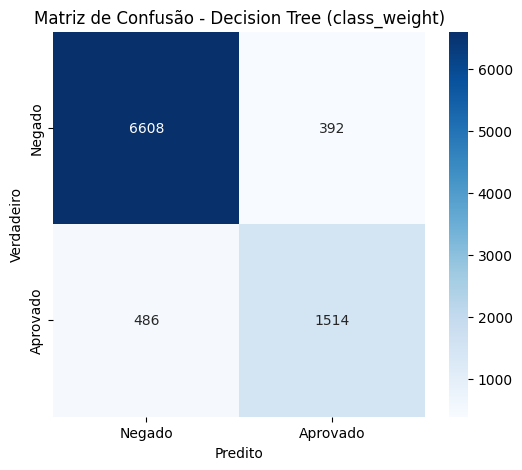

----- Avaliação do Modelo: Random Forest (class_weight) -----
Acurácia: 0.9269
ROC AUC Score: 0.9723

Relatório de Classificação:
              precision    recall  f1-score   support

  Negado (0)       0.93      0.98      0.95      7000
Aprovado (1)       0.90      0.76      0.82      2000

    accuracy                           0.93      9000
   macro avg       0.92      0.87      0.89      9000
weighted avg       0.93      0.93      0.92      9000



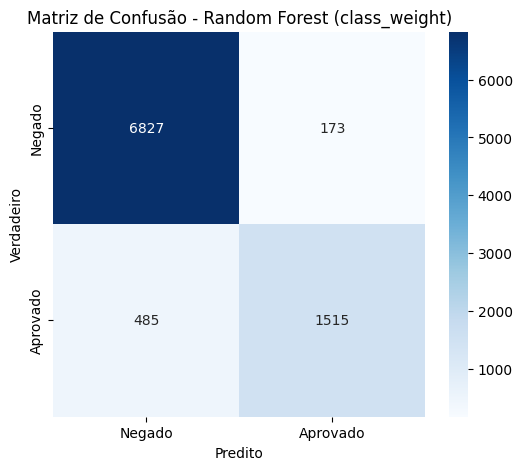

----- Avaliação do Modelo: XGBoost (class_weight) -----
Acurácia: 0.9198
ROC AUC Score: 0.9783

Relatório de Classificação:
              precision    recall  f1-score   support

  Negado (0)       0.97      0.93      0.95      7000
Aprovado (1)       0.78      0.89      0.83      2000

    accuracy                           0.92      9000
   macro avg       0.87      0.91      0.89      9000
weighted avg       0.93      0.92      0.92      9000



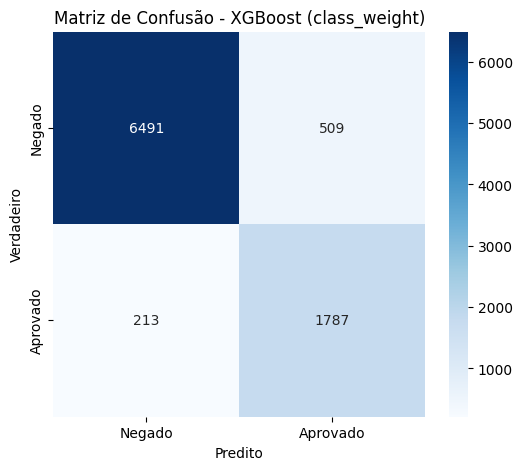

In [43]:
modelos_cw = {
    'Decision Tree': DecisionTreeClassifier(class_weight='balanced', random_state=42),
    'Random Forest': RandomForestClassifier(class_weight='balanced', random_state=42, n_jobs=-1),
    'XGBoost': XGBClassifier(scale_pos_weight=(sum(y_train==0)/sum(y_train==1)), eval_metric='logloss', random_state=42, n_jobs=-1)
}

for name, model in modelos_cw.items():
    model.fit(X_train_processado, y_train)
    
    y_pred = model.predict(X_test_processado)
    y_prob = model.predict_proba(X_test_processado)[:, 1]
    
    resultados[f'{name} (class_weight)'] = avaliar_modelo(f'{name} (class_weight)', y_test, y_pred, y_prob)

#### Treinamento dos modelos no cenário com SMOTE

Distribuição da variável alvo no treinamento antes do SMOTE:
0: 0.777778
1: 0.222222

Distribuição da variável alvo no treinamento depois do SMOTE:
1: 0.500000
0: 0.500000
 
----- Avaliação do Modelo: Decision Tree (SMOTE) -----
Acurácia: 0.8966
ROC AUC Score: 0.8581

Relatório de Classificação:
              precision    recall  f1-score   support

  Negado (0)       0.94      0.93      0.93      7000
Aprovado (1)       0.76      0.79      0.77      2000

    accuracy                           0.90      9000
   macro avg       0.85      0.86      0.85      9000
weighted avg       0.90      0.90      0.90      9000



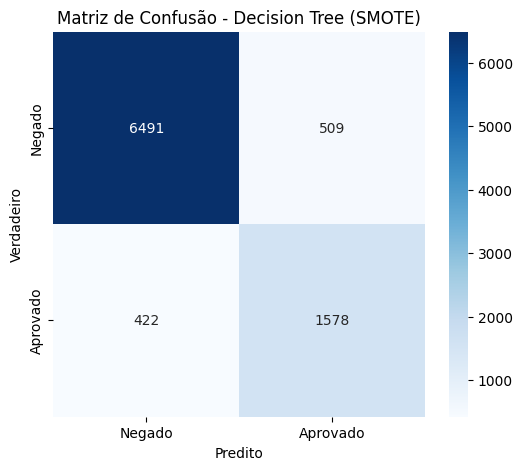

----- Avaliação do Modelo: Random Forest (SMOTE) -----
Acurácia: 0.9236
ROC AUC Score: 0.9703

Relatório de Classificação:
              precision    recall  f1-score   support

  Negado (0)       0.94      0.96      0.95      7000
Aprovado (1)       0.86      0.79      0.82      2000

    accuracy                           0.92      9000
   macro avg       0.90      0.88      0.89      9000
weighted avg       0.92      0.92      0.92      9000



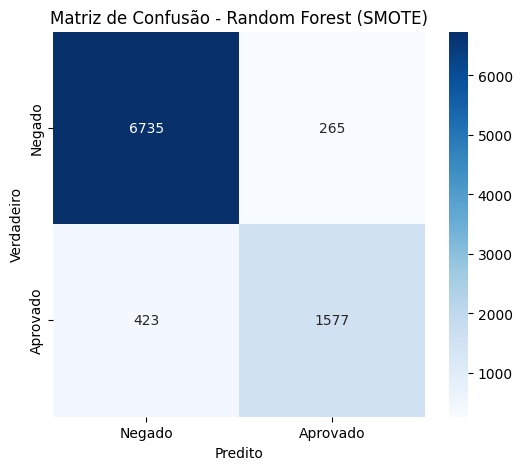

----- Avaliação do Modelo: XGBoost (SMOTE) -----
Acurácia: 0.9330
ROC AUC Score: 0.9777

Relatório de Classificação:
              precision    recall  f1-score   support

  Negado (0)       0.95      0.97      0.96      7000
Aprovado (1)       0.88      0.81      0.84      2000

    accuracy                           0.93      9000
   macro avg       0.91      0.89      0.90      9000
weighted avg       0.93      0.93      0.93      9000



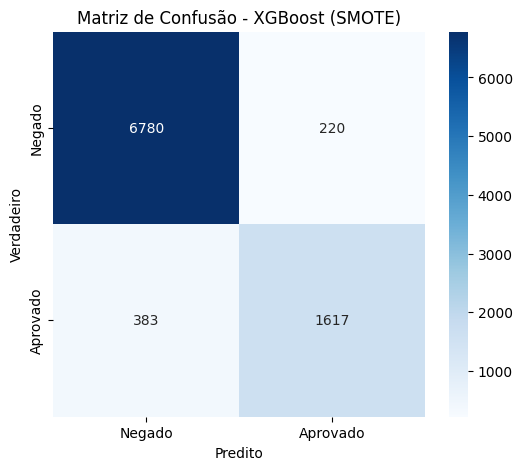

In [44]:
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_processado, y_train)

print("Distribuição da variável alvo no treinamento antes do SMOTE:")
for classe, proporcao in y_train.value_counts(normalize=True).items():
    print(f"{classe}: {proporcao:.6f}")

print("\nDistribuição da variável alvo no treinamento depois do SMOTE:")
for classe, proporcao in y_train_smote.value_counts(normalize=True).items():
    print(f"{classe}: {proporcao:.6f}")
print(" ")


modelos_smote = {
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42, n_jobs=-1),
    'XGBoost': XGBClassifier(eval_metric='logloss', random_state=42, n_jobs=-1)
}

for name, model in modelos_smote.items():
    model.fit(X_train_smote, y_train_smote)
    
    y_pred = model.predict(X_test_processado)
    y_prob = model.predict_proba(X_test_processado)[:, 1]
    
    resultados[f'{name} (SMOTE)'] = avaliar_modelo(f'{name} (SMOTE)', y_test, y_pred, y_prob)